In [1]:
%matplotlib inline
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
mtx = np.load('data/mtx.npy')
dist = np.load('data/dist.npy')

### Load images

In [3]:
import glob

test_files = glob.glob('test_images/*.jpg')
test_imgs = []
for file in test_files:
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    test_imgs.append(np.flip(img, 2)) # opencv uses bgr instead of rgb

In [ ]:
plt.imshow(test_imgs[1])

In [ ]:
broken_images = np.load('broken_images/broken_images.npy')

### Undistort images

In [4]:
def undistort_img(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst
    

In [5]:
undistorted_imgs = []
for img in test_imgs:
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    undistorted_imgs.append(dst)

In [ ]:
img = undistorted_imgs[2]

### Thresholding

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def combined_sobel_thresh(image):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined.astype(np.uint8)

In [46]:
def img_histogram_eq(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
    return img_output

def color_threshold(img, color_model, low, high):
    hls = cv2.cvtColor(img, color_model)
    
    channel_thresh_img = np.zeros_like(img)
    hsv_binary = np.zeros(img.shape[:1])
    for i in range(img.shape[-1]):
        idx = (hls[...,i] >= low[i]) & (hls[...,i] <= high[i])
        channel_thresh_img[idx, i] = 1
    hsv_binary = channel_thresh_img[..., 0] & channel_thresh_img[..., 1] & channel_thresh_img[..., 2]
    return hsv_binary

def combined_color_thresh(img):
    hls_img_y = color_threshold(img, cv2.COLOR_RGB2HLS, [0,100,90], [40,255,255])
    lab_img_y = color_threshold(img, cv2.COLOR_RGB2LAB, [0,0,155], [255,255,200])
    lab_img_w = color_threshold(img, cv2.COLOR_RGB2LAB, [196,0,0], [255,255,255])
    luv_img_w = color_threshold(img, cv2.COLOR_RGB2LUV, [200,0,0], [255,255,255])
    
    combined = np.zeros_like(hls_img_y)
    for img in [hls_img_y, lab_img_y, lab_img_w, luv_img_w]:
        combined = combined | img
    return combined.astype(np.uint8)


In [44]:
def combined_thresh(sobel_binary, color_binary):
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[(sobel_binary == 1) | (color_binary == 1)] = 1
    return combined_binary.astype(np.uint8)

def threshold_image(img):
    sobel_binary = combined_sobel_thresh(img)
    color_binary = combined_color_thresh(img)
    return combined_thresh(sobel_binary, color_binary)

def plot_threshold(sobel_binary, color_binary, original):    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    stacked_binary = np.dstack(( np.zeros_like(sobel_binary), sobel_binary, color_binary)) * 255
    
    combined_binary = combined_thresh(sobel_binary, color_binary)
    
#     plt.figure()
#     plt.imshow(original)
#     plt.figure()
#     plt.imshow(sobel_binary)
#     plt.figure()
#     plt.imshow(color_binary)
#     plt.figure()
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(stacked_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')

#### Example

In [ ]:
show_img = undistorted_imgs[2]
# show_img = broken_images[10]

sobel_binary = combined_sobel_thresh(show_img)
color_binary = combined_color_thresh(show_img)
combined_binary = combined_thresh(sobel_binary, color_binary)
plot_threshold(sobel_binary, color_binary, show_img)

### Region Masking

In [38]:

def draw_polygon(img, vertices, color=[255, 0, 0], thickness=2):
    img = img.copy()
    vertices = np.array(vertices, dtype=np.int32)
    for i in range(len(vertices)):
        cv2.line(img, tuple(vertices[i-1]), tuple(vertices[i]), color, thickness)
    return img
    
def get_src(img):
    h, w = img.shape[:2]
    mid1, mid2 = [(w*.441), (h*.64)], [(w*.565), (h*.642)]
    bot1, bot2 = [(w*.08), h], [(w*.95), h]
    vertices = [mid1, mid2, bot2, bot1]
    return vertices

def get_dst(img):
    h, w = img.shape[:2]
    offsetx=100
    offsety=-10
    mid1, mid2 = [offsetx, offsety], [w-offsetx, offsety]
    bot1, bot2 = [offsetx, h], [w-offsetx, h]
    dst = [mid1, mid2, bot2, bot1]
    return dst


#### Example

In [ ]:
src = get_src(img)
poly_img = draw_polygon(img, src)
plt.imshow(poly_img)

### Perspective transform

In [10]:
def warp_image(img):
    src = np.float32(get_src(img))
    dst = np.float32(get_dst(img))
    h, w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (w, h))
    return warped, M, Minv


#### Example

In [ ]:
# warped = warp_image(poly_img)
warped, M, Minv = warp_image(combined_binary)
plt.imshow(warped)

### Convolution

In [11]:

# Read in a thresholded image
# warped = mpimg.imread('warped_example.jpg')

# window settings
window_width = 65
window_height = 90 # Break image into 9 vertical layers since image height is 720
margin = 50 # How much to slide left and right for searching

from scipy.signal import gaussian

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
#     window = np.ones(window_width) # Create our window template that we will use for convolutions
    window = gaussian(window_width, std=window_width, sym=True)

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        if np.sum(conv_signal[l_min_index:l_max_index]) < 1000:
            l_center = (l_min_index + l_max_index) / 2 - offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        if np.sum(conv_signal[r_min_index:r_max_index]) < 1000:
            r_center = (r_min_index + r_max_index) / 2 - offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def draw_centroids(image, window_centroids):
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(image)
        r_points = np.zeros_like(image)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,image,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,image,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((image, image, image))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((image,image,image)),np.uint8)
    return output

#### Example

In [ ]:
window_centroids = find_window_centroids(warped, window_width, window_height, margin)
# Display the final results
output = draw_centroids(warped, window_centroids)
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [ ]:
img = undistorted_imgs[0]

combined_binary = threshold_image(img)
image, M, Minv = warp_image(combined_binary)

window_centroids = [] # Store the (left,right) window centroid positions per level
#     window = np.ones(window_width) # Create our window template that we will use for convolutions
window = gaussian(window_width, std=window_width / 2, sym=True)

# First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
# and then np.convolve the vertical image slice with the window template 

# Sum quarter bottom of image to get slice, could use a different ratio
l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
l_center = np.argmax(np.convolve(window,l_sum))-window_width/2

print(image.shape)
print(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)].shape)
print(l_sum.shape)
print(window)
# np.convolve(window,l_sum)

### Fit quadratic curve

In [ ]:
window_centroids

In [12]:
def get_centroid_coordinates(window_centroids):
    centy = []
    leftx = []
    rightx = []
    for idx, (l, r) in enumerate(window_centroids):
        y = (len(window_centroids) - idx) * window_height - window_height/2
        centy.append(y)
        leftx.append(l)
        rightx.append(r)
    return centy, leftx, rightx

def fit_centroids(centy, leftx, rightx):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(centy, leftx, 2)
    right_fit = np.polyfit(centy, rightx, 2)
    
    return left_fit, right_fit

In [13]:
def fit_coordinates(binary_warped, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx
    
def plot_lane_lines(binary_warped, ploty, left_fitx, right_fitx):
    plt.figure()
    plt.imshow(binary_warped)
#     plt.plot(leftx, centy, 'bo', color='blue')
#     plt.plot(rightx, centy, 'bo', color='blue')
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    

#### Example

In [ ]:
binary_warped, M, Minv = warp_image(combined_binary)

window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)
out_img = draw_centroids(binary_warped, window_centroids)

centy, leftx, rightx = get_centroid_coordinates(window_centroids)
left_fit, right_fit = fit_centroids(centy, leftx, rightx)
ploty, left_fitx, right_fitx = fit_coordinates(binary_warped, left_fit, right_fit)

plot_lane_lines(binary_warped, ploty, left_fitx, right_fitx)

### Measuring curvature

In [14]:
def curvature_pixels(img, left_fit, right_fit):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
#     y_eval = np.max(ploty)
    y_eval = img.shape[0]-1
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad
    # Example values: 1926.74 1908.48

In [15]:
def curvature_meters(img, centy, leftx, rightx):
    y_eval = img.shape[0]-1
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fit_cr = np.polyfit(np.array(centy)*ym_per_pix, np.array(leftx)*xm_per_pix, 2)
    right_fit_cr = np.polyfit(np.array(centy)*ym_per_pix, np.array(rightx)*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

In [37]:
def meters_off(img, left_fit, right_fit):
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    screen_middel_pixel = img.shape[1]/2
    left_lane_pixel = np.poly1d(left_fit)(img.shape[0]-1)
    right_lane_pixel = np.poly1d(right_fit)(img.shape[0]-1)
    car_middle_pixel = int((right_lane_pixel + left_lane_pixel)/2)
    screen_off_center = screen_middel_pixel-car_middle_pixel
    meters_off_center = xm_per_pix * screen_off_center
    return meters_off_center

### Overlay onto original image

In [17]:
def overlay_img(warped, ploty, left_fitx, right_fitx, Minv, undist):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    image = warped
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result
#     plt.imshow(result)

### Putting it all together

In [34]:
def run_all(img):
    # Threshold
    combined_binary = threshold_image(img)
    sobel_binary = combined_sobel_thresh(img)
    color_binary = combined_color_thresh(img)
    plot_threshold(sobel_binary, color_binary, img)
    
    # Guiding lines
    src = get_src(img)
    poly_img = draw_polygon(img, src)
    plt.figure()
    plt.imshow(poly_img)

    # Perspective warp (original)
    poly_warped_img, M, Minv = warp_image(poly_img)
    plt.figure()
    plt.imshow(poly_warped_img)
    
    # Perspective warp (threshold)
    warped_img, M, Minv = warp_image(combined_binary)
    plt.figure()
    plt.imshow(warped_img)
    
    # Sliding window search with centroids
    window_centroids = find_window_centroids(warped_img, window_width, window_height, margin)
    centroid_img = draw_centroids(warped_img, window_centroids)
    plt.figure()
    plt.imshow(centroid_img)

    # Fit polynomial to find lane lines
    centy, leftx, rightx = get_centroid_coordinates(window_centroids)
    left_fit, right_fit = fit_centroids(centy, leftx, rightx)
    ploty, left_fitx, right_fitx = fit_coordinates(centroid_img, left_fit, right_fit)
    plot_lane_lines(centroid_img, ploty, left_fitx, right_fitx)
    
    lfp = np.poly1d(left_fit)
    rfp = np.poly1d(right_fit)
    print(lfp(720))
    print(rfp(720))
    
    linear_leftfit = np.polyfit(centy, leftx, 1)
    linear_rightfit = np.polyfit(centy, rightx, 1)
    print('Left slope:', linear_leftfit)
    print('Right slope:', linear_rightfit)
    
    left_curverad, right_curverad = curvature_meters(centroid_img, centy, leftx, rightx)
    print(left_curverad, 'm', right_curverad, 'm')
    
    meters_off_center = meters_off(centroid_img, left_fit, right_fit)
    print('Meters off center: {}m'.format(meters_off_center))
    
    overlay = overlay_img(warped_img, ploty, left_fitx, right_fitx, Minv, img)
    plt.imshow(overlay)

246.21875
1277.26264881
Left slope: [ -1.60449735e-01   3.70636905e+02]
Right slope: [  1.27050265e-01   1.17532440e+03]
1609.88958551 m 1368.35017362 m
Meters off center: -0.6395714285714286m


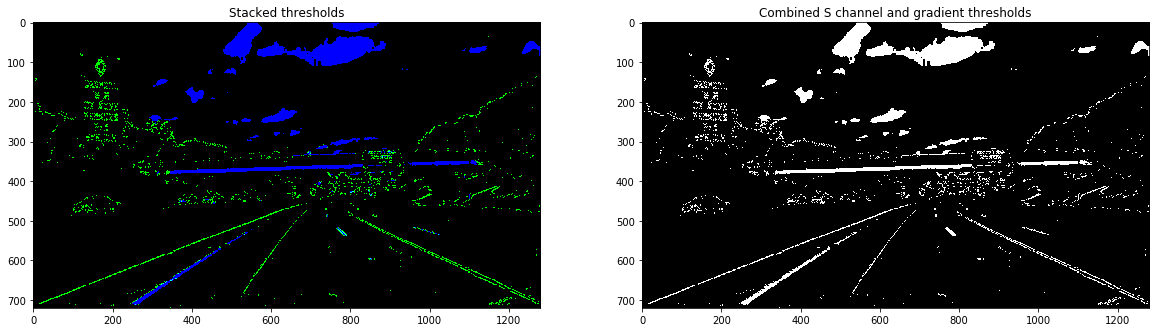

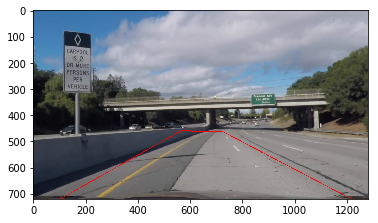

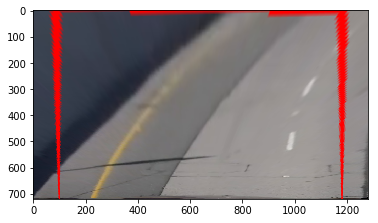

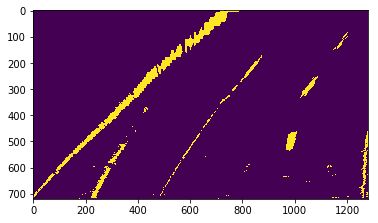

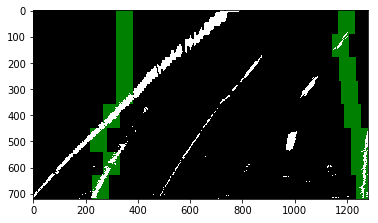

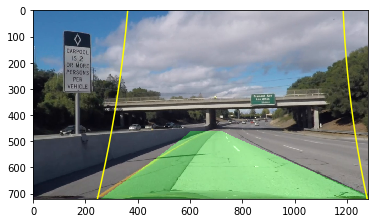

In [47]:
#  run_all(undistorted_imgs[7])
run_all(broken_images[10])

## Test on video

In [22]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
from scipy.misc import imsave

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = overlay_pipeline(image)
    return result

broken_images = []

def overlay_pipeline(img):
    global broken_images
    undist_img = undistort_img(img)
    # Threshold
    combined_binary = threshold_image(undist_img)

    # Perspective warp (threshold)
    warped_img, M, Minv = warp_image(combined_binary)
    
    # Sliding window search with centroids
    window_centroids = find_window_centroids(warped_img, window_width, window_height, margin)
    centroid_img = draw_centroids(warped_img, window_centroids)

    # Fit polynomial to find lane lines
    centy, leftx, rightx = get_centroid_coordinates(window_centroids)
    left_fit, right_fit = fit_centroids(centy, leftx, rightx)
    ploty, left_fitx, right_fitx = fit_coordinates(centroid_img, left_fit, right_fit)
    
    # Save any images we do poorly on
    lfp = np.poly1d(left_fit)(720)
    rfp = np.poly1d(right_fit)(720)
    if lfp < 150 or lfp > 320:
        broken_images.append(undist_img)
    if rfp < 1000 or rfp > 1250:
        broken_images.append(undist_img)
    
    left_curverad, right_curverad = curvature_meters(centroid_img, centy, leftx, rightx)
    avg_curverad = (left_curverad + right_curverad) / 2
    curve_str = 'Curve Radius: {}m'.format( np.round(avg_curverad, 2))
#     print(left_curverad, 'm', right_curverad, 'm')
    
    meters_off_center = meters_off(centroid_img, leftx, rightx)
    center_str = 'Meters off center: {}m'.format(np.round(meters_off_center, 2))
#     print(center_str)
    
    overlay = overlay_img(warped_img, ploty, left_fitx, right_fitx, Minv, undist_img)
    
    cv2.putText(overlay,curve_str, (50,50), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=[255, 255, 255], thickness=4)
    cv2.putText(overlay,center_str, (50,100), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=[255, 255, 255], thickness=4)
    return overlay

In [ ]:
# output = overlay_pipeline(undistorted_imgs[0])
output = overlay_pipeline(broken_images[10])
plt.imshow(output)

In [24]:

output = 'output_video/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [05:04<00:00,  4.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 4min 47s, sys: 1min 10s, total: 5min 57s
Wall time: 5min 5s


In [25]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [27]:
print('# of images lane detection failed:', len(broken_images))
np.save('broken_images/broken_images.npy', broken_images)

### Challenge video

In [39]:
output = 'output_video/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_video/challenge_video.mp4
[MoviePy] Writing video output_video/challenge_video.mp4


100%|██████████| 485/485 [01:58<00:00,  4.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/challenge_video.mp4 

CPU times: user 1min 51s, sys: 27.1 s, total: 2min 18s
Wall time: 1min 58s


In [40]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [41]:
print('# of images lane detection failed:', len(broken_images))
np.save('broken_images/broken_challenge_images.npy', broken_images)

# of images lane detection failed: 271
